# Generating/Building VictoryNet

Imports: 

In [1]:
import pandas as pd
import numpy as np
import keras as ks
from keras.callbacks import TensorBoard
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Reading the file and splitting off the target variable. 

In [2]:
df = pd.read_csv("indexByMatch_batchUdacity_205_CLEANED_NORM.csv", index_col="Unnamed: 0")
labels = df["alphaVictory"]
df.drop("alphaVictory", axis=1, inplace=True)

In the next cell, we take the data from Pandas into Numpy so that our NN can read it easily.

In [3]:
data = df.as_matrix(columns=df.columns[:])
label = labels.as_matrix()

Checking the Shape of the data. 

In [4]:
print(data.shape)
print(label.shape)

(124236, 204)
(124236,)


Splitting the data into: 

70% Training

20% Testing

10% Validation

In [5]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.3, random_state=444)

X_TEST, X_VALID, y_TEST, y_VALID = train_test_split(X_test, y_test, test_size = 0.33, random_state=123)

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_TEST.shape)
print(y_TEST.shape)

(86965, 204)
(86965,)
(24971, 204)
(24971,)


Setting up the file to hold our learning curves using the Tensorflow backend of Keras.

In [7]:
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

Building our network. This was done using Huang et al's equations. They are equations 1, 2, and 3 in this paper: 

http://dstath.users.uth.gr/papers/IJRS2009_Stathakis.pdf

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(511, activation='relu', input_dim=204))
model.add(Dense(170, activation='relu', input_dim=511))
model.add(Dense(1, activation='sigmoid'))


Compiling the Network

In [9]:
model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Fitting the Network and using Validation data to double check the learning process and prevent overfitting. 

In [10]:
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_VALID, y_VALID), callbacks=[tbCallBack])

Train on 86965 samples, validate on 12300 samples
Epoch 1/10
86965/86965 [==============================] - 2s - loss: 0.2037 - acc: 0.9146 - val_loss: 0.1763 - val_acc: 0.9267
Epoch 2/10
86965/86965 [==============================] - 2s - loss: 0.1736 - acc: 0.9275 - val_loss: 0.1799 - val_acc: 0.9237
Epoch 3/10
86965/86965 [==============================] - 2s - loss: 0.1597 - acc: 0.9338 - val_loss: 0.1640 - val_acc: 0.9307
Epoch 4/10
86965/86965 [==============================] - 2s - loss: 0.1467 - acc: 0.9392 - val_loss: 0.1452 - val_acc: 0.9398
Epoch 5/10
86965/86965 [==============================] - 2s - loss: 0.1368 - acc: 0.9439 - val_loss: 0.1371 - val_acc: 0.9428
Epoch 6/10
86965/86965 [==============================] - 2s - loss: 0.1291 - acc: 0.9473 - val_loss: 0.1310 - val_acc: 0.9464
Epoch 7/10
86965/86965 [==============================] - 2s - loss: 0.1235 - acc: 0.9485 - val_loss: 0.1277 - val_acc: 0.9473
Epoch 8/10
86965/86965 [==============================] - 2s 

Testing VictoryNet

In [11]:
score = model.evaluate(X_TEST, y_TEST, batch_size=128)

24704/24971 [============================>.] - ETA: 0s

Printing the final score for VictoryNet achieved with the test data.

In [12]:
print(model.metrics_names)
print(score)

['loss', 'acc']
[0.12520358885303609, 0.94850026030195023]


In [13]:
# from keras.utils import plot_model
# plot_model(model, to_file='model.png')

Saving the model.

In [14]:
model.save("predictingMatchesNN.h5")

Some metrics and visualizations

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

In [16]:
y_test_predict = model.predict(X_TEST, batch_size=128, verbose=1)

20864/24971 [========================>.....] - ETA: 0s

In [17]:
print(y_test_predict, y_test)

[[  1.25403586e-03]
 [  9.26450372e-01]
 [  1.26048461e-01]
 ..., 
 [  3.66369181e-06]
 [  2.04602300e-04]
 [  9.99997616e-01]] [ 1.  0.  1. ...,  0.  1.  0.]


In [18]:
y_prob_to_class = []
for each_value in y_test_predict:
    if each_value[0] < 0.5:
        y_prob_to_class.append(0)
    else:
        y_prob_to_class.append(1)

In [19]:
import seaborn as sb

cm = confusion_matrix(y_prob_to_class, y_TEST)
print(cm)

[[11708   473]
 [  813 11977]]


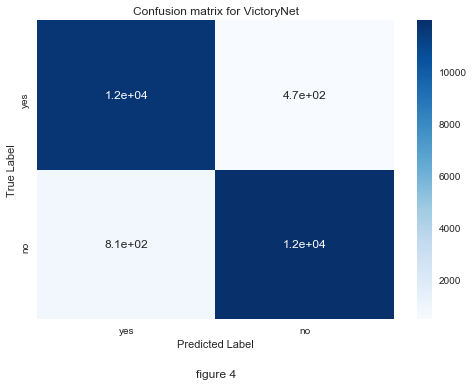

In [20]:
sb.heatmap(cm, annot=True, cmap="Blues", xticklabels=['yes', 'no'], yticklabels=['yes', 'no'])
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion matrix for VictoryNet")
plt.figtext(x=0.4, y=-0.02, s = "figure 4")

In [21]:
print(classification_report(y_prob_to_class, y_TEST))

             precision    recall  f1-score   support

          0       0.94      0.96      0.95     12181
          1       0.96      0.94      0.95     12790

avg / total       0.95      0.95      0.95     24971



In [22]:
# train_acc = pd.read_csv("training_acc.csv")
# train_loss = pd.read_csv("training_loss.csv")
# valid_acc = pd.read_csv("valid_acc.csv")
# valid_loss = pd.read_csv("valid_loss.csv")

In [23]:
# train_acc.drop(["Wall time", "Step"], axis=1, inplace=True)
# train_loss.drop(["Wall time", "Step"], axis=1, inplace=True)
# valid_acc.drop(["Wall time", "Step"], axis=1, inplace=True)
# valid_loss.drop(["Wall time", "Step"], axis=1, inplace=True)

In [24]:
# print(train_acc)
# print(train_loss)
# print(valid_acc)
# print(valid_loss)

In [25]:
# train_acc.columns = ["Training Accuracy"]
# ax = train_acc.plot()
# train_loss.plot(ax=ax)
# plt.title("Loss and Accuracy for training data")
# plt.xlabel("Epochs")
# plt.figtext(x=0.47, y=-0.02, s = "figure 5")

In [26]:
# valid_acc.columns = ["Validation Accuracy"]
# axs = valid_acc.plot()
# valid_loss.plot(ax=axs)
# plt.title("Loss and Accuracy for Validation data")
# plt.xlabel("Epochs")
# plt.figtext(x=0.47, y=-0.02, s = "figure 6")